In [73]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import islice

## Initial datasets

In [111]:
movies_df = pd.read_csv('./ml-latest-small/movies.csv')
print(movies_df)
len(movies_df)

      movieId                                      title  \
0           1                           Toy Story (1995)   
1           2                             Jumanji (1995)   
2           3                    Grumpier Old Men (1995)   
3           4                   Waiting to Exhale (1995)   
4           5         Father of the Bride Part II (1995)   
...       ...                                        ...   
9737   193581  Black Butler: Book of the Atlantic (2017)   
9738   193583               No Game No Life: Zero (2017)   
9739   193585                               Flint (2017)   
9740   193587        Bungo Stray Dogs: Dead Apple (2018)   
9741   193609        Andrew Dice Clay: Dice Rules (1991)   

                                           genres  
0     Adventure|Animation|Children|Comedy|Fantasy  
1                      Adventure|Children|Fantasy  
2                                  Comedy|Romance  
3                            Comedy|Drama|Romance  
4                  

9742

In [112]:
ratings_df = pd.read_csv('./ml-latest-small/ratings.csv')
ratings_df

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


In [113]:
# userId as rows and movieId as columns
user_rating_df = ratings_df.pivot(index='userId', columns='movieId', values='rating')

# Normalizing
norm_user_rating_df = user_rating_df.fillna(0) / 5.0
trX = norm_user_rating_df.values
print(len(trX))
trX[0:10]

610
610


array([[0.8, 0. , 0.8, ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       ...,
       [0. , 0.8, 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ]])

In [114]:
hiddenUnits = 20 # need to test tbh
visibleUnits = len(user_rating_df.columns)
vb = tf.Variable(tf.zeros([visibleUnits]), tf.float32) # visible layers are the movies
hb = tf.Variable(tf.zeros([hiddenUnits]), tf.float32) # number of features/hidden layers
W = tf.Variable(tf.zeros([visibleUnits, hiddenUnits]), tf.float32)

v0 = tf.zeros([visibleUnits], tf.float32)
tf.matmul([v0], W)

<tf.Tensor: shape=(1, 20), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]], dtype=float32)>

In [115]:
def hidden_layer(v0_state, W, hb):
    h0_prob = tf.nn.sigmoid(tf.matmul([v0_state], W) + hb) # the stochastic update rule
    h0_state = tf.nn.relu(tf.sign(h0_prob - tf.random.uniform(tf.shape(h0_prob))))
    return h0_state

h0 = hidden_layer(v0, W, hb)

def reconstruction(h0, W, vb):
    v1_prob = tf.nn.sigmoid(tf.matmul(h0, tf.transpose(W)) + vb) 
    v1_state = tf.nn.relu(tf.sign(v1_prob - tf.random.uniform(tf.shape(v1_prob)))) 
    return v1_state[0]

v1 = reconstruction(h0, W, vb)

hidden state shape:  (1, 20)
v0 state shape:   (9724,)
v1 state shape:   (9724,)


In [116]:
def error(v0_state, v1_state):
    return tf.reduce_mean(tf.square(v0_state - v1_state))

err = tf.reduce_mean(tf.square(v0 - v1))
print("error" , err.numpy())

error 0.49557796


In [117]:
epochs = 5
batchsize = 100
errors = []
weights = []
K=1
alpha = 0.1

Epoch: 1, batch #: 0 of 6, sample #: 99, reconstruction error: 0.02100575901567936
Epoch: 1, batch #: 1 of 6, sample #: 99, reconstruction error: 0.03408987820148468
Epoch: 1, batch #: 2 of 6, sample #: 99, reconstruction error: 0.005591320339590311
Epoch: 1, batch #: 3 of 6, sample #: 99, reconstruction error: 0.0053064581006765366
Epoch: 1, batch #: 4 of 6, sample #: 99, reconstruction error: 0.008646647445857525
Epoch: 1, batch #: 5 of 6, sample #: 99, reconstruction error: 0.051806867122650146
Epoch: 1, batch #: 6 of 6, sample #: 9, reconstruction error: 0.10177189856767654
Epoch: 2, batch #: 0 of 6, sample #: 99, reconstruction error: 0.021993007510900497
Epoch: 2, batch #: 1 of 6, sample #: 99, reconstruction error: 0.03172460198402405
Epoch: 2, batch #: 2 of 6, sample #: 99, reconstruction error: 0.004624640103429556
Epoch: 2, batch #: 3 of 6, sample #: 99, reconstruction error: 0.004442616831511259
Epoch: 2, batch #: 4 of 6, sample #: 99, reconstruction error: 0.009037433192133

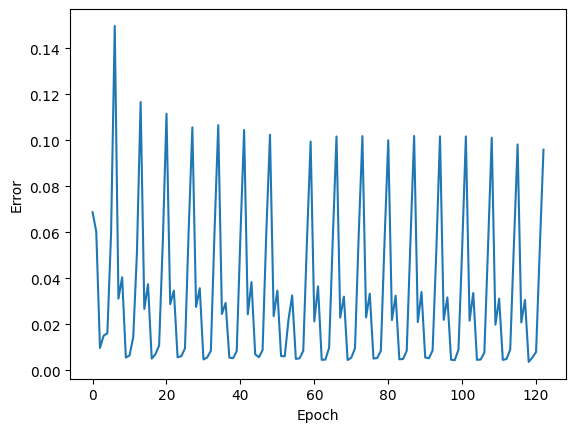

In [131]:
#creating datasets
train_ds = \
    tf.data.Dataset.from_tensor_slices((np.float32(trX))).batch(batchsize)

v0_state=v0
for epoch in range(epochs):
    batch_number = 0
    for batch_x in train_ds:

        for i_sample in range(len(batch_x)):           
            for k in range(K):
                # positive phase
                v0_state = batch_x[i_sample]
                h0_state = hidden_layer(v0_state, W, hb)

                # negative phase
                v1_state = reconstruction(h0_state, W, vb)
                h1_state = hidden_layer(v1_state, W, hb)

                delta_W = tf.matmul(tf.transpose([v0_state]), h0_state) - tf.matmul(tf.transpose([v1_state]), h1_state)
                W = W + alpha * delta_W

                vb = vb + alpha * tf.reduce_mean(v0_state - v1_state, 0)
                hb = hb + alpha * tf.reduce_mean(h0_state - h1_state, 0) 

                v0_state = v1_state

            if i_sample == len(batch_x)-1:
                err = error(batch_x[i_sample], v1_state)
                errors.append(err)
                weights.append(W)
                print(f"Epoch: {epoch + 1}, batch #: {batch_number} of {int(len(trX) / batchsize)}, sample #: {i_sample}, reconstruction error: {err}")

        batch_number += 1




plt.plot(errors)
plt.ylabel('Error')
plt.xlabel('Epoch')
plt.show()

## Testing

In [140]:
user_id = 400

# Reshaping for 2D
inputUser = trX[user_id].reshape(1, -1)

inputUser = tf.convert_to_tensor(trX[user_id],"float32")

inputUser.shape

v0test = tf.zeros([visibleUnits], tf.float32)
h0test = tf.nn.sigmoid(tf.matmul([inputUser], W) + hb)

v1test = tf.nn.sigmoid(tf.matmul(h0test, tf.transpose(W)) + vb)

rec = v1test

tf.maximum(rec,1)

scored_movies_df = movies_df[movies_df['movieId'].isin(user_rating_df.columns)]
scored_movies_df = scored_movies_df_mock.assign(recommendation = rec[0])

user_movies_df = ratings_df[ratings_df['userId'] == user_id]
merged_df = scored_movies_df.merge(user_movies_df, on='movieId', how='outer')
merged_df.sort_values(["recommendation"], ascending=False).head(20)

,movieId,title,genres,recommendation,userId,rating,timestamp
7285,76093,How to Train Your Dragon (2010),Adventure|Animation|Children|Fantasy|IMAX,0.976055,400.0,4.5,1.498870e+09
9205,152081,Zootopia (2016),Action|Adventure|Animation|Children|Comedy,0.951563,NaN,NaN,NaN
6388,50872,Ratatouille (2007),Animation|Children|Drama,0.925384,NaN,NaN,NaN
4070,5816,Harry Potter and the Chamber of Secrets (2002),Adventure|Fantasy,0.911959,NaN,NaN,NaN
3569,4896,Harry Potter and the Sorcerer's Stone (a.k.a. ...,Adventure|Children|Fantasy,0.901839,NaN,NaN,NaN
6045,40815,Harry Potter and the Goblet of Fire (2005),Adventure|Fantasy|Thriller|IMAX,0.901837,NaN,NaN,NaN
8457,112852,Guardians of the Galaxy (2014),Action|Adventure|Sci-Fi,0.897326,NaN,NaN,NaN
5156,8368,Harry Potter and the Prisoner of Azkaban (2004),Adventure|Fantasy|IMAX,0.883692,NaN,NaN,NaN
7195,72998,Avatar (2009),Action|Adventure|Sci-Fi|IMAX,0.831720,NaN,NaN,NaN
7061,69844,Harry Potter and the Half-Blood Prince (2009),Adventure|Fantasy|Mystery|Romance|IMAX,0.828908,NaN,NaN,NaN
